Steps
- Load and normalize the CIFAR10 training and test datasets using torchvision
- Define a Convolutional Neural Network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

In [1]:
%pylab inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import trange
from tqdm import tqdm
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



Populating the interactive namespace from numpy and matplotlib


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=24, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=24, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


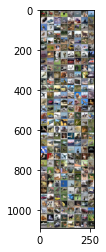

  car horse plane  bird  deer  ship horse plane   dog   car  deer  bird truck   car  ship  frog  bird   cat truck  deer  deer  deer   cat  frog  bird   dog  ship  deer truck plane   cat  frog truck  ship   cat truck horse  ship   dog horse   car  deer   dog  frog truck   car  ship   cat  ship  deer   dog  bird truck  frog   car plane  bird plane horse horse   car horse   dog   car  frog   dog  deer truck plane  bird   dog plane  bird  bird  frog   dog plane truck   cat  ship   dog truck   cat  bird  ship truck  ship truck truck horse  ship truck truck  deer  ship  ship plane  deer  ship  ship truck   dog  ship  frog  bird   car  ship plane  deer  bird  bird horse plane  deer plane   cat   car   cat plane   cat horse   car plane  ship   dog  bird horse   car plane truck  bird horse   car  bird  deer  bird plane horse  bird truck plane  frog  bird   cat horse plane horse   cat plane   cat  deer   car  bird plane  ship truck  ship  ship  ship  frog plane  frog   dog  deer plane  bird  dee

In [3]:

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Train on CPU

In [5]:
# CPU
device = torch.device('cpu')
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
EPOCH = 20
for epoch in range(EPOCH):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(t:= tqdm(trainloader, 0, position=0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        t.set_description("Epoch: %.d/%.d. loss %.2f" % (epoch+1, EPOCH , loss))
        #if i % 2000 == 1999:    # print every 2000 mini-batches
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0

print('Finished CPU Training')

  0%|          | 0/196 [00:00<?, ?it/s]/home/wan268/.conda/envs/dl/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch: 20/20. loss 1.37: 100%|██████████| 196/196 [00:13<00:00, 14.38it/s]

Finished CPU Training


In [6]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(testloader, position=0):
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

100%|██████████| 40/40 [00:02<00:00, 18.31it/s]

Accuracy of the network on the 10000 test images: 45 %


# Train on single GPU

In [7]:
# GPU
device=torch.device('cuda:0')
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
EPOCH = 20
for epoch in range(EPOCH):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(t:=tqdm(trainloader, 0, position=0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        t.set_description("Epoch: %.d/%.d. loss %.2f" % (epoch+1, EPOCH , loss))

print('Finished Training')

Epoch: 20/20. loss 1.34: 100%|██████████| 196/196 [00:01<00:00, 122.19it/s]

Finished Training


# Test 

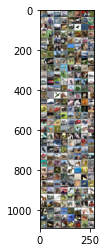

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(testloader, position=0):
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

100%|██████████| 40/40 [00:00<00:00, 42.86it/s]

Accuracy of the network on the 10000 test images: 48 %


In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 54.6 %
Accuracy for class car   is: 66.9 %
Accuracy for class bird  is: 31.3 %
Accuracy for class cat   is: 27.8 %
Accuracy for class deer  is: 29.3 %
Accuracy for class dog   is: 46.9 %
Accuracy for class frog  is: 64.0 %
Accuracy for class horse is: 57.9 %
Accuracy for class ship  is: 53.1 %
Accuracy for class truck is: 48.8 %


# Train on multiple GPUs

In [12]:
# Multiple GPUs
device=torch.device('cuda:0')
net = Net()
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  net = nn.DataParallel(net)
net = net.to(device)

Let's use 8 GPUs!


In [13]:

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters())
EPOCH = 20
for epoch in range(EPOCH):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(t:=tqdm(trainloader, 0, position=0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        t.set_description("Epoch: %.d/%.d. loss %.2f" % (epoch+1, EPOCH , loss))

print('Finished Multi GPUs Training')

Epoch: 20/20. loss 0.78: 100%|██████████| 196/196 [00:03<00:00, 51.11it/s]

Finished Multi GPUs Training


In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(testloader, position=0):
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

100%|██████████| 40/40 [00:01<00:00, 22.94it/s]

Accuracy of the network on the 10000 test images: 66 %


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 60.8 %
Accuracy for class car   is: 79.6 %
Accuracy for class bird  is: 57.6 %
Accuracy for class cat   is: 41.7 %
Accuracy for class deer  is: 59.6 %
Accuracy for class dog   is: 57.7 %
Accuracy for class frog  is: 77.2 %
Accuracy for class horse is: 75.7 %
Accuracy for class ship  is: 80.2 %
Accuracy for class truck is: 77.8 %
